## Classification of gravitational waves

This [dataset](https://www.kaggle.com/c/g2net-gravitational-wave-detection) consists of of time series data containing simulated gravitational wave measurements from a network of 3 gravitational wave interferometers (LIGO Hanford, LIGO Livingston, and Virgo). 
Each time series contains either detector noise or detector noise plus a simulated gravitational wave signal. 
The task is to identify when a signal is present in the data (target=1).

All signals have been simulated. In this simulations, the parameters that determine the exact form of a binary black hole waveform are the masses, sky location, distance, black hole spins, binary orientation angle, gravitational wave polarisation, time of arrival, and phase at coalescence (merger). 
These parameters (15 in total) have been randomised according to astrophysically motivated prior distributions and used to generate the simulated signals present in the data, but are not provided as part of the competition data.

Each data sample (.npy file) contains 3 time series (1 for each detector) and each spans 2 sec and is sampled at 2,048 Hz.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import config
import engine
import utils
from src.signal_generator import SignalGenerator
from src.dataset import G2dataset, makeDataloader
from src.stats_logger import StatsLogger
from src.model import Net

Check class balance and plot a few samples:

Class ratio:  0.500125


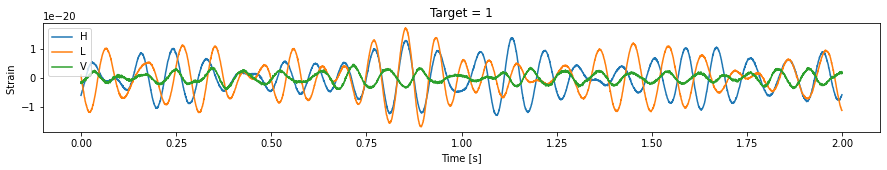

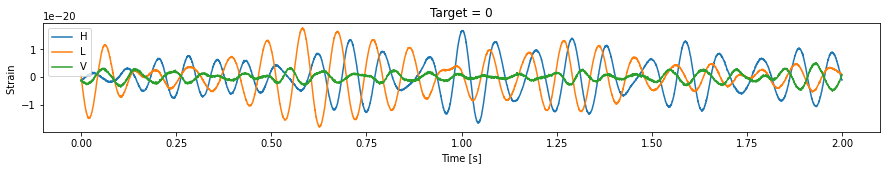

In [5]:
# Read labels
df = pd.read_csv("/data/training_labels.csv")
print('Class ratio: ', df[df['target'] == 0].shape[0] / df.shape[0])

for idx in range(2):
    
    sampleID = df['id'][idx]
    data     = utils.load(sampleID)
    label    = df['target'].loc[idx]
    
    plt.figure(figsize = (15, 2))
    plt.plot(np.arange(data.shape[1]) / config.SAMPLE_FREQUENCY, data.T);
    plt.title(f'Target = {label}');
    plt.xlabel('Time [s]')
    plt.ylabel('Strain ')
    plt.legend(['H', 'L', 'V'])
    plt.show();

## Data split

Simple train/val/test split for training:

In [7]:
traindf, testdf = utils.dataSplit(df, testSize = config.TEST_RATIO, seed = 123)
traindf, valdf  = utils.dataSplit(traindf, testSize = config.VAL_RATIO, seed = 1234)

## Preprocessing

The usual preprocessing pipeline when searching for graviational signals is the [following](https://www.gw-openscience.org/tutorials/):
Given a signal, the first step is to apply a windowing function (Tukey), followed by whitening (de-noising), and bandpass filtering. These steps have been implemented in the utils module and are embedded in the dataset class.

To whiten the signals, the design curves of the detectors are required (an example of these curves can be found [here](https://www.researchgate.net/publication/342436340_Searching_for_gravitational_waves_produced_by_cosmic_strings_in_LIGO-Virgo_data)).
For this dataset, these curves can be estimated from all the examples that contain noise (i.e. label = 0):

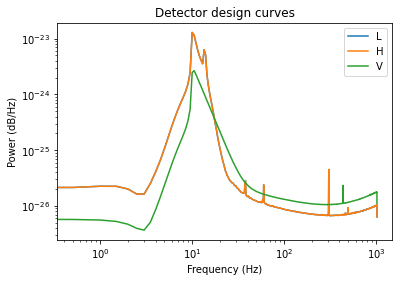

In [112]:
dfNoise  = traindf[traindf['target'] == 0]
psdNoise = utils.spectralNoiseEstimate(dfNoise)
np.savetxt(config.NOISE_FILE, psdNoise, delimiter = ',')

plt.loglog(psdNoise[0,:], psdNoise[1:, :].T)
plt.legend(['L', 'H', 'V'])
plt.title('Detector design curves');
plt.xlabel('Frequency (Hz)');
plt.ylabel('Power (dB/Hz)');

### Generation of synthetic signals

Additional samples can be generated using the [pyCBC package](https://github.com/gwastro/pycbc), which can generate black hole collision signals given a set of parameters, as well as noise. This has been implemented in the SignalGenerator class:

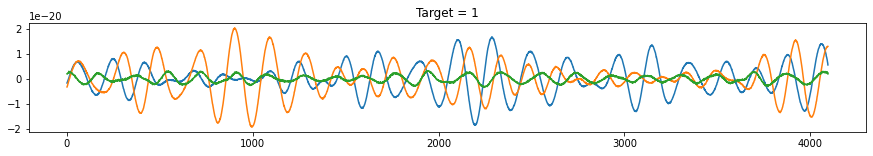

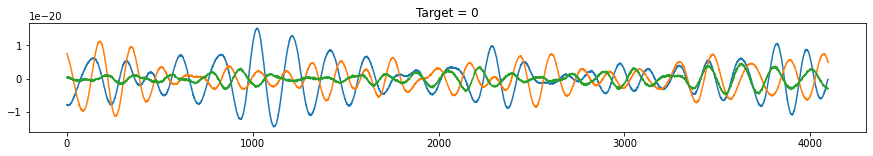

In [6]:
sigGen  = SignalGenerator()

for idx in range(2):
    
    sig, label = sigGen.generate()
    plt.figure(figsize = (15, 2))
    plt.plot(sig.T);
    plt.title(f'Target = {label}');
    plt.show()

The *synthetic* signals above do not look that much different from the ones provided in this dataset. Training with both the original and the synthetic signals will help prevent overfitting. 
Pretraining is not used here. Instead, in the dataset class a synthetic or real signal is randomly selected with a ratio of 60 (real) / 40 (synthetic).

Below is a mix of real/synthetic signals after the preprocessing pipeline has been applied:

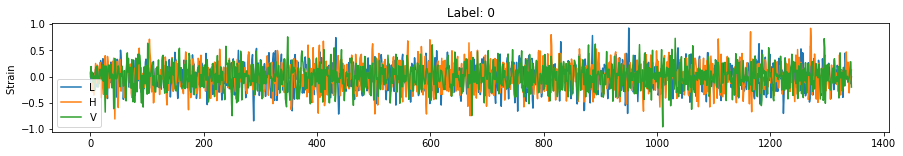

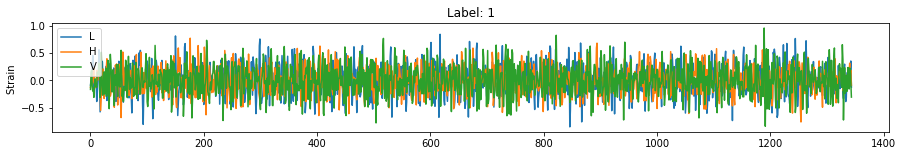

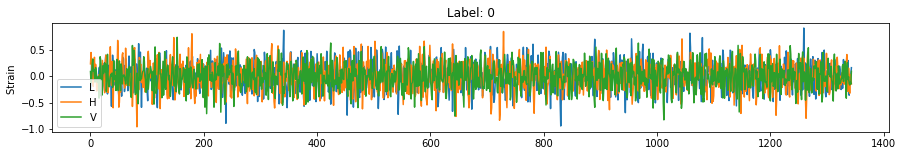

In [115]:
for idx in range(3):
    
    # Load and preprocess the sample
    data, label = G2dataset(fileList   = traindf['id'].values,
                     targetList = traindf['target'].values).__getitem__(idx)

    plt.figure(figsize = (15, 2))
    plt.plot(data.T);
    plt.title(f'Label: {int(label)}')
    plt.ylabel('Strain ')
    plt.legend(['L', 'H', 'V'])
    plt.show();

## Modelling

A simple 1D convnet has been used (Model class), consisting of a set of conv1d -> batchNorm -> Activation blocks, some followed by a MaxPool operations and global average pooling.

In [ ]:
trainloader    = makeDataloader(traindf)
valloader      = makeDataloader(valdf)
testloader      = makeDataloader(testdf)
noTrainSamples = len(trainloader.dataset) 
noValSamples   = len(valloader.dataset)
scheduler      = None
scaler         = torch.cuda.amp.GradScaler()
criterion      = nn.BCEWithLogitsLoss()
metric         = utils.computeAUROC
stats          = StatsLogger(filename = config.STATS_FILE)
model          = Net().to(config.DEVICE)
optimizer      = torch.optim.AdamW(model.parameters(), lr = config.LEARN_RATE, weight_decay = config.WEIGHT_DECAY)

In [ ]:
model, optimizer, scheduler, scaler, curEpoch, bestValLoss = utils.loadCheckpoint(model, optimizer, scheduler, scaler)

for epoch in range(curEpoch, config.EPOCHS):
    
    trainLoss, trainMetric = engine.train(model, criterion, metric, trainloader, optimizer, scaler, verbose = False)
    valLoss, valMetric     = engine.validate(model, criterion, metric, valloader, verbose = False)
    
    valLoss   /= noValSamples
    trainLoss /= noTrainSamples

    if scheduler is not None: scheduler.step(valLoss)
    stats(trainLoss, valLoss, trainMetric, valMetric)
    bestValLoss = utils.makeCheckpoint(epoch, model, optimizer, valLoss, bestValLoss, scheduler, scaler)
    
stats.save()

Plot training results:

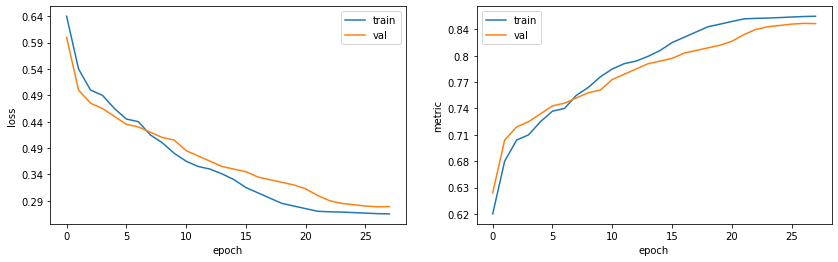

In [110]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4))

ax[0].plot(stats.trainLoss)
ax[0].plot(stats.valLoss)
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'])

ax[1].plot(stats.trainMetric)
ax[1].plot(stats.valMetric)
ax[1].set_ylabel('metric')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val']);

Validation loss AUROC is approximately equal to 0.84. Check performance on the test set:

In [119]:
_, testMetric = engine.validate(model, criterion, metric, testloader, verbose = False)
print(f'Test set AUROC: {testMetric:.3f}')

Test set AUROC: 0.843
